In [1]:
! pip install lime

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 15.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283839 sha256=967dfe7645c28b80350f15cb139e077c28c3a76bcaa871165f898c0afc06bcf6
  Stored in directory: /root/.cache/pip/wheels/fd/a2/af/9ac0a1a85a27f314a06b39e1f492bee1547d52549a4606ed89
Successfully built lime


In [2]:
!gdown 1EHW25MVmJTlTZJLpRn_jFIld-BP5WN-S
!gdown 1GFZL2Y8D2ihj_Sy_v1mNkvu5TYAtJ1nR
!gdown 168j27eDDxCbn1Ujf-OV3Q-Gp6s89-KMW
!wget https://raw.githubusercontent.com/pytorch/hub/master/imagenet_classes.txt

Downloading...
From: https://drive.google.com/uc?id=1EHW25MVmJTlTZJLpRn_jFIld-BP5WN-S
To: /content/dog-kitten.jpeg
100% 64.9k/64.9k [00:00<00:00, 99.8MB/s]
Downloading...
From: https://drive.google.com/uc?id=1GFZL2Y8D2ihj_Sy_v1mNkvu5TYAtJ1nR
To: /content/dog.jpeg
100% 77.9k/77.9k [00:00<00:00, 98.6MB/s]
Downloading...
From: https://drive.google.com/uc?id=168j27eDDxCbn1Ujf-OV3Q-Gp6s89-KMW
To: /content/cat.png
100% 1.25M/1.25M [00:00<00:00, 123MB/s]
--2023-05-16 19:17:10--  https://raw.githubusercontent.com/pytorch/hub/master/imagenet_classes.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10472 (10K) [text/plain]
Saving to: ‘imagenet_classes.txt’

imagenet_classes.tx 100%[===================>]  10.23K  --.-KB/s    in 0s      

2023-05-16 19:17:11 (92.2 MB

In [3]:
import torch
import urllib
from PIL import Image
from torchvision import transforms
import numpy as np
from lime import lime_image
from skimage.segmentation import mark_boundaries
import matplotlib.pyplot as plt

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [5]:
model = torch.hub.load('pytorch/vision:v0.10.0', 'mobilenet_v2', pretrained=True)
model.eval();

Downloading: "https://github.com/pytorch/vision/zipball/v0.10.0" to /root/.cache/torch/hub/v0.10.0.zip
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/mobilenet_v2-b0353104.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v2-b0353104.pth
100%|██████████| 13.6M/13.6M [00:00<00:00, 355MB/s]


In [6]:
dog_file = open('dog.jpeg', 'rb')   
dog_image =  Image.open(dog_file).convert('RGB')  

dog_cat_file = open('dog-kitten.jpeg', 'rb')   
dog_cat_image =  Image.open(dog_cat_file).convert('RGB')  

cat_file = open('cat.png', 'rb')   
cat_image =  Image.open(cat_file).convert('RGB')  

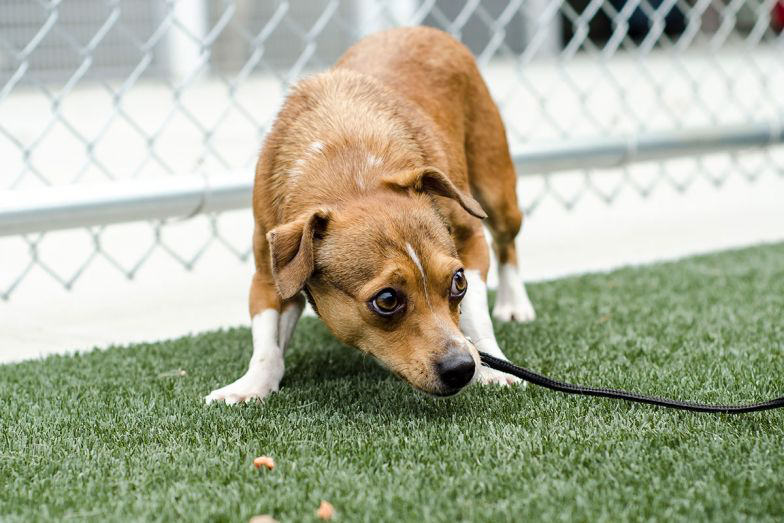

In [ ]:
dog_image.show()

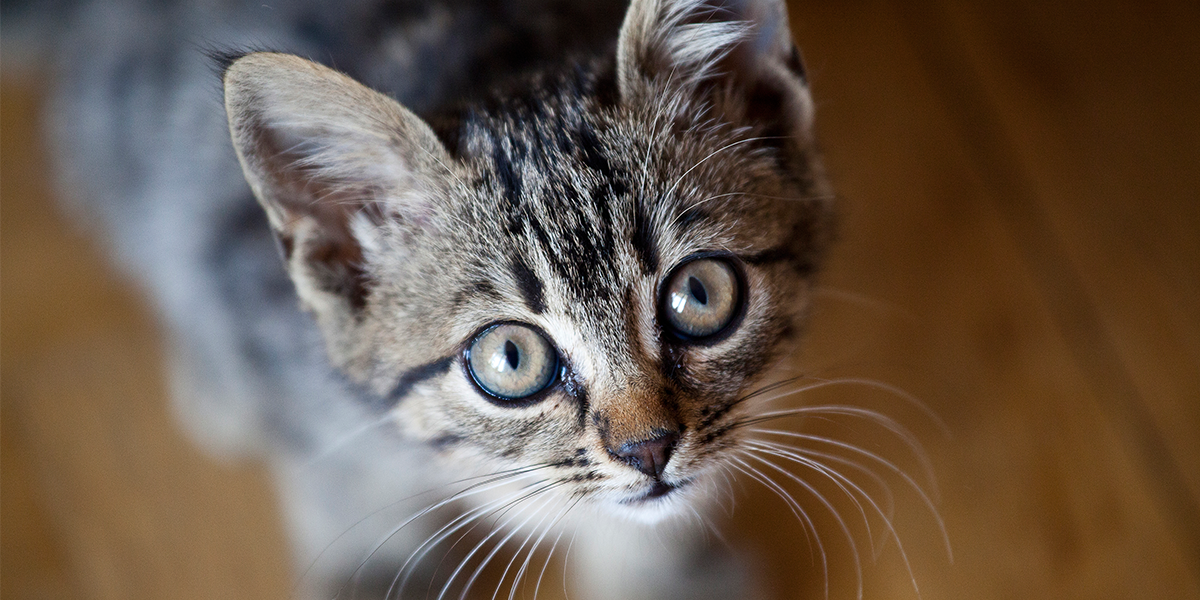

In [ ]:
cat_image.show()

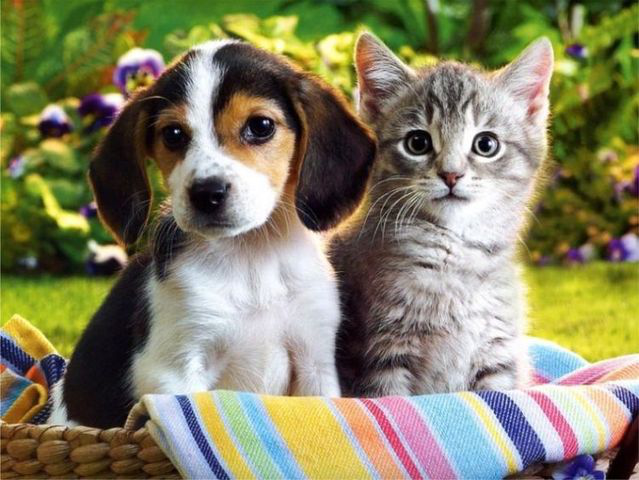

In [ ]:
dog_cat_image.show()

In [7]:
resize_crop = transforms.Compose([
        transforms.Resize((256, 256)),
        transforms.CenterCrop(224)
])    

tensor = transforms.Compose([
        transforms.ToTensor()
])

In [8]:
def predict(images):
    batch = torch.stack(tuple(tensor(image) for image in images), dim=0)
    model.to(device)
    batch = batch.to(device)
    
    logits = model(batch)
    probs = torch.nn.functional.softmax(logits, dim=1)
    return probs.detach().cpu().numpy()

In [9]:
def get_top5(image):
  probabilities = torch.from_numpy(predict([resize_crop(image)]).squeeze())
  with open("imagenet_classes.txt", "r") as f:
      categories = [s.strip() for s in f.readlines()]
  # Show top categories per image
  top5_prob, top5_catid = torch.topk(probabilities, 5)
  for i in range(top5_prob.size(0)):
      print(categories[top5_catid[i]], top5_prob[i].item())

In [10]:
class ImageExplainer():
  def __init__(self,input_image):
    self.explainer = lime_image.LimeImageExplainer()
    self.explanation = self.explainer.explain_instance(np.array(resize_crop(input_image)), predict, top_labels=5, hide_color=0, num_samples=1000)

  def draw_boundry_image(self,pred_num):
    temp, mask = self.explanation.get_image_and_mask(self.explanation.top_labels[pred_num], positive_only=True, num_features=5, hide_rest=False)
    img_boundry1 = mark_boundaries(temp, mask)
    plt.imshow(img_boundry1)
    plt.show()

  def draw_pros_cons(self,pred_num):
    temp, mask = self.explanation.get_image_and_mask(self.explanation.top_labels[pred_num], positive_only=False, num_features=10, hide_rest=False) 
    plt.imshow(mark_boundaries(temp, mask))
    plt.show()

  def draw_hitmap(self,pred_num):
    ind =  self.explanation.top_labels[pred_num]
    dict_heatmap = dict(self.explanation.local_exp[ind])
    heatmap = np.vectorize(dict_heatmap.get)(self.explanation.segments) 
    plt.imshow(heatmap, cmap = 'RdBu', vmin  = -heatmap.max(), vmax = heatmap.max())
    plt.colorbar()

DOG
Labrador retriever 0.6585021018981934
American Staffordshire terrier 0.12135866284370422
golden retriever 0.05020306259393692
redbone 0.014067724347114563
dingo 0.012581673450767994


  0%|          | 0/1000 [00:00<?, ?it/s]

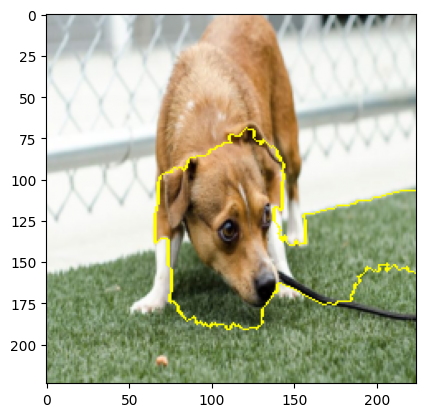

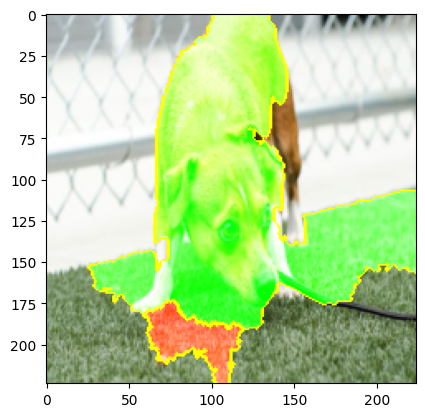

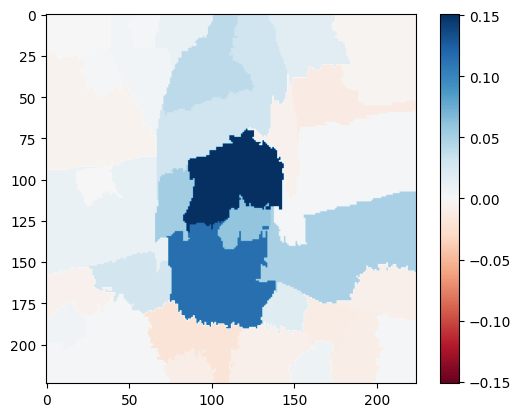

In [ ]:
print("DOG")
get_top5(dog_image)
explainer = ImageExplainer(dog_image)
explainer.draw_boundry_image(0)
explainer.draw_pros_cons(0)
explainer.draw_hitmap(0)

CAT
Egyptian cat 0.5172398090362549
tabby 0.16973239183425903
tiger cat 0.11068528145551682
plastic bag 0.053881481289863586
lynx 0.04483482614159584


  0%|          | 0/1000 [00:00<?, ?it/s]

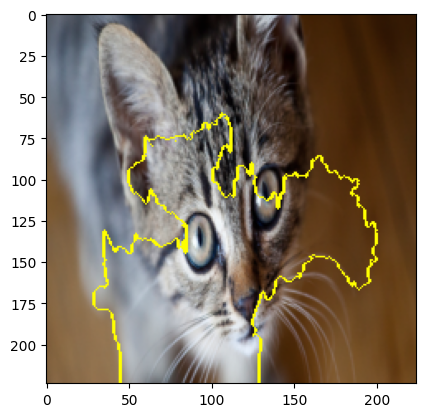

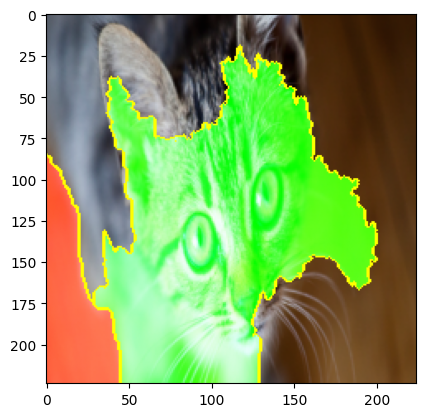

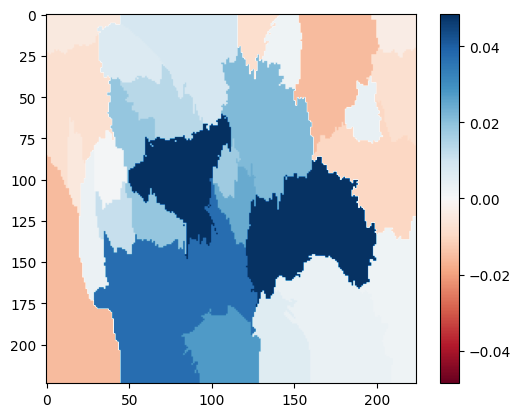

In [ ]:
print("CAT")
get_top5(cat_image)
explainer = ImageExplainer(cat_image)
explainer.draw_boundry_image(0)
explainer.draw_pros_cons(0)
explainer.draw_hitmap(0)

DOG-CAT
beagle 0.42868441343307495
carton 0.19388310611248016
Brittany spaniel 0.02289739064872265
Egyptian cat 0.01852933131158352
bow tie 0.01694798283278942


  0%|          | 0/1000 [00:00<?, ?it/s]

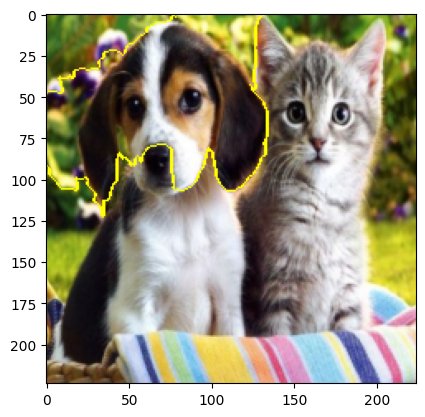

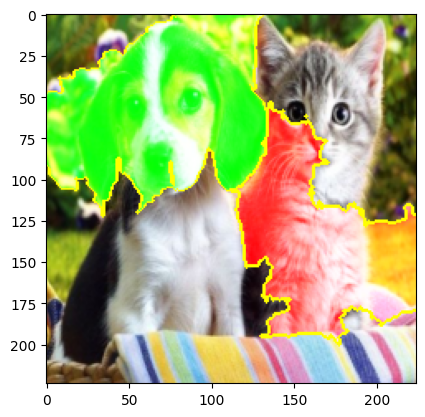

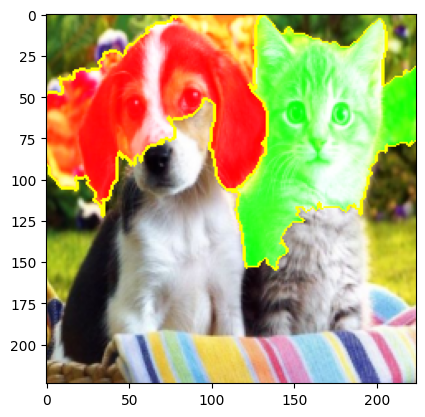

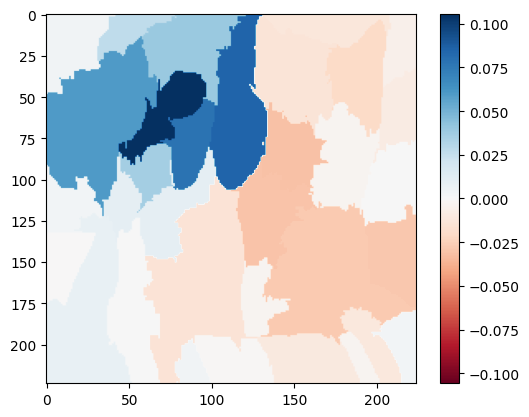

In [14]:
print("DOG-CAT")
get_top5(dog_cat_image)
dog_explainer = ImageExplainer(dog_cat_image)
dog_explainer.draw_boundry_image(0)
dog_explainer.draw_pros_cons(0)
dog_explainer.draw_pros_cons(3)
dog_explainer.draw_hitmap(0)